# 웹 스크래핑을 사용한 데이터 분석

- 증권 데이터 분석을 하려면 종목코드를 알아야 한다.
- 전체 종목코드가 있어야 종목별로 급등 순위, 시가총액 순위 등의 통계를 낼 수 있기 때문이다.
- 종목코드 다운로드
    + 1) 한국거래소 기업공시채널(kind.krx.co.kr) 접속 및 `상장법인상세정보` -> `상장법인목록`
    + 2) EXCEL 버튼을 눌러 상장법인 목록을 다운받는다.
- 해당 파일은 xls 확장자이지만 html 파일이므로 `pandas`의 `read_html`을 사용해야 읽어 올 수 있다.
- 아래 html 주소로부터 바로 종목코드를 가져올 수 있다.

- 종목코드는 6자리이므로 아래와 같이 `format`메서드를 활용해 수정해준다.

In [1]:
import pandas as pd

In [2]:
krx_html_path = "https://kind.krx.co.kr/corpgeneral/corpList.do?method=download&searchType=13"
krx_list = pd.read_html(krx_html_path)
krx_list[0]['종목코드'] = krx_list[0]['종목코드'].map(lambda x: '{:06d}'.format(x))
df = krx_list[0]
df = df.sort_values(by='종목코드', ascending=False)
df

,회사명,종목코드,업종,주요제품,상장일,결산월,대표자명,홈페이지,지역
2256,네오이뮨텍,950220,자연과학 및 공학 연구개발업,면역항암제,2021-03-16,12월,양세환,http://neoimmunetech.co.kr,미국
1920,프레스티지바이오파마,950210,자연과학 및 공학 연구개발업,바이오시밀러 및 항체의약품 신약,2021-02-05,06월,박소연,http://www.prestigebiopharma.com,싱가포르
2310,소마젠,950200,"그외 기타 전문, 과학 및 기술 서비스업","유전체 분석 서비스 (NGS, CES 등)",2020-07-13,12월,Ryan W. Kim (김운봉),NaN,미국
1683,미투젠,950190,소프트웨어 개발 및 공급업,"캐주얼게임, 소셜카지노게임",2020-08-18,12월,린즈웨이/라우호밍,http://www.me2zen.com,홍콩
1028,SNK,950180,소프트웨어 개발 및 공급업,"IP 라이센스, 콘솔, 모바일 게임",2019-05-07,07월,갈지휘,http://www.snk-corp.co.jp,일본
...,...,...,...,...,...,...,...,...,...
1580,삼양홀딩스,000070,기타 금융업,"지주회사,경영자문컨설팅",1968-12-27,12월,"엄태웅, 윤재엽",http://www.samyang.com,서울특별시
1576,메리츠화재,000060,보험업,"손해보험(화재,해상,운송보험)",1956-07-02,12월,김용범,http://www.meritzfire.com,서울특별시
1554,경방,000050,종합 소매업,"섬유류(면사,면혼방사,면직물,면혼방직물,화섬사,화섬직물) 제조,도매,수출입",1956-03-03,12월,"김준, 김담",http://www.kyungbang.co.kr,서울특별시
305,KR모터스,000040,그외 기타 운송장비 제조업,"이륜차(오토바이) 제조,도매",1976-05-25,12월,노성석,http://www.krmotors.com,경상남도


## 웹에서 일별 시세 구하기

- 네이버 금융에 접속하면 한국거래소에 상장된 종목의 일별 시세를 확인 할 수 있다.
- `beautifulsoup4`를 활용하여 셀트리온의 일별시세를 크롤링한다.
- 원하는 종목을 검색 후 일별시세 페이지를 눌러보고 페이지 소스를 누르면 아래와 같은 주소를 얻을 수 있다.
    + "view-source:https://finance.naver.com/item/sise.naver?code=068270"
- 페이지까지 주소에 찍힐려면 일별시세의 페이지 숫자에 오른쪽 마우스버튼을 누른 후 링크 주소 복사를 하면 된다.
    + https://finance.naver.com/item/sise_day.naver?code=068270&page=10
- URL을 그냥 사용하면 안된다. User Agent 정보가 설정되어야한다.
    + 참고 : https://ekyoo.tistory.com/15

In [3]:
import pandas as pd

In [4]:
from bs4 import BeautifulSoup
from urllib import request as req
from urllib.request import urlopen
from tqdm import tqdm
import mplfinance as mpf
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'D2Coding'

In [5]:
url = "https://finance.naver.com/item/sise_day.nhn?code=068270&page=1"
headers = ("User-Agent", "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/93.0.4577.82 Safari/537.36")

opener = req.build_opener()
opener.addheaders = [headers]

In [6]:
with opener.open(url) as response:
    doc = BeautifulSoup(response, 'lxml')
    pgrr = doc.find('td', class_='pgRR')
    # print(pgrr.a['href'])
    last_page = pgrr.a['href'].split("=")[-1]

In [7]:
last_page

'401'

In [8]:
df = pd.DataFrame()
sise_url = "https://finance.naver.com/item/sise_day.nhn?code=068270" # 셀트리온 종목코드 : 068270

for page in tqdm(range(1, int(last_page)+1)):
    page_url = '{}&page={}'.format(sise_url, page)
    response = opener.open(page_url)
    df = df.append(pd.read_html(response, header=0)[0])
    
df = df.dropna()
df = df.drop(columns=['전일비'])

100%|██████████| 401/401 [00:24<00:00, 16.18it/s]


In [9]:
df = df.rename(columns={'날짜': 'Date', '시가': 'Open', '고가': 'High', '저가': 'Low', '종가': 'Close', '거래량': 'Volume'})
df = df.sort_values(by='Date')
df.index = pd.to_datetime(df['Date'])
df = df[['Open', 'High', 'Low', 'Close', 'Volume']]

In [10]:
df.tail()

,Open,High,Low,Close,Volume
Date,,,,,
2021-09-23,287000.0,291000.0,282500.0,284500.0,1233089.0
2021-09-24,285000.0,285500.0,274000.0,274500.0,633897.0
2021-09-27,272000.0,272500.0,267000.0,267500.0,512408.0
2021-09-28,265000.0,269500.0,263000.0,263500.0,515609.0
2021-09-29,259500.0,265000.0,259500.0,263500.0,128593.0


In [11]:
mini_df = df.tail(30)

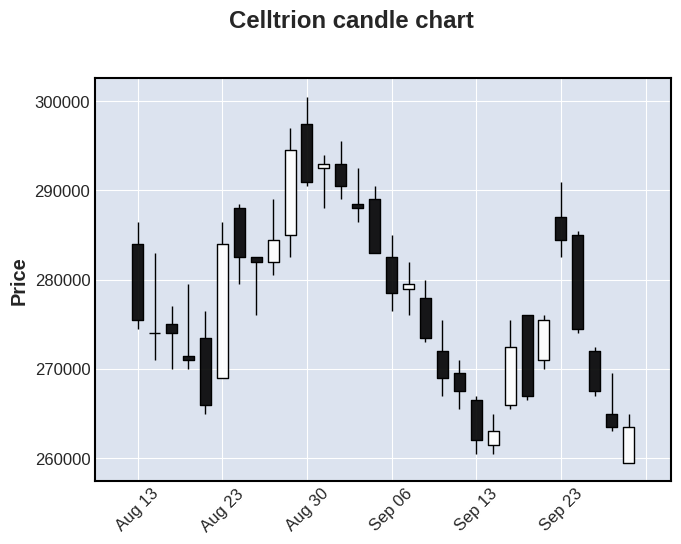

In [12]:
mpf.plot(mini_df, title='Celltrion candle chart', type="candle")

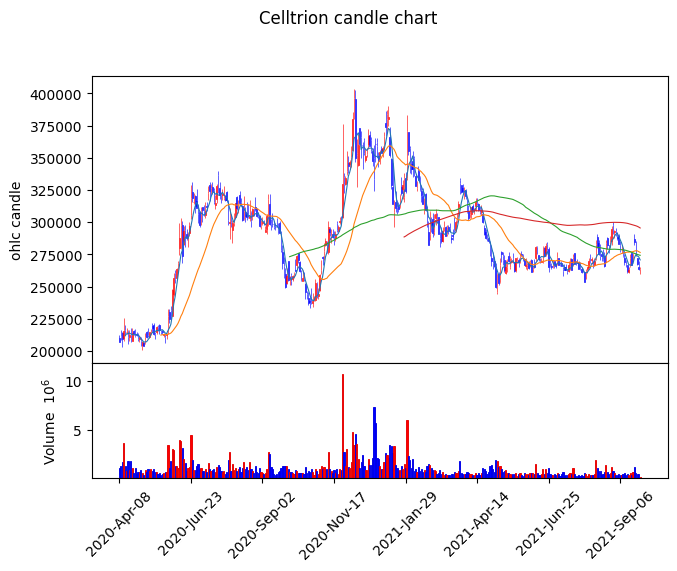

In [14]:
kwargs = dict(
    title='Celltrion candle chart', 
    type="candle",
    mav=(5, 30, 120, 200),
    volume=True,
    ylabel='ohlc candle',
)
mc = mpf.make_marketcolors(up='r', down='b', inherit=True)
s = mpf.make_mpf_style(marketcolors=mc)
mpf.plot(df.tail(365), **kwargs, style=s)